In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import pandas as pd
import datetime as dt
import plotly.express as px
import seaborn as sns 

import os
import re
import requests
from sklearn import linear_model

#ML libraries
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE


In [22]:
def MAPE(predicted, actual,log2_input=True): 
    if log2_input:
        predicted = 2**predicted
        actual = 2**actual
    error = actual-predicted
    abs_error = np.abs(error)
    abs_perc_error = (abs_error/actual)*100
    print('--------------------------------')
    print('Testing Model Absolute Percentage error (APE)')
    print(f'Median APE (MAPE) = {abs_perc_error.median():.2f}%')
    print(f'Mean APE  = {abs_perc_error.mean():.2f} %')
    print(f"25th percentile APE = {abs_perc_error.quantile(q=0.25):.2f} %")
    print(f"75th percentile APE = {abs_perc_error.quantile(q=0.75):.2f} %")


In [23]:
# defince a constant for the sol base unit of 1000000000
SOL_BASE = 1000000000


## Import Traits/Rarity Data 

In [26]:
all_dirs = next(os.walk('data'))[1]
collections = []
for i in all_dirs:
    files =  os.listdir(f'data/{i}/')
    correct_files = all(x in files for x in ['transactions.csv','rarity.csv' ])
    if correct_files:
        collections.append(i)
     

#drop solana_monkey_business
collections.remove('solana_monkey_business')

collections

['trippin_ape_tribe', 'okay_bears', 'primates', 'justape']

In [27]:

trait_dfs ={}
trait_list ={}
slug = {'justape':'ape', 'okay_bears':'okay_bears',
        'primates':'primates','trippin_ape_tribe':'trippin_ape_tribe'}
for i in collections:
    df = pd.read_csv(f"data/{i}/rarity.csv")
    df = df.replace('None', np.nan)
    rarity_cols = df.filter(regex='_rarity',axis=1).columns
    collection_trait_list=[]
    for col in rarity_cols:
        prefix = re.sub("_rarity", "", col)
        if prefix in df.columns:
            collection_trait_list.append(prefix)

    df['trait_n'] = df[collection_trait_list].count(axis=1)

    #get mint_id 
    
    url = f'https://moonrank.app/mints/{slug[i]}?after=0&seen={df.shape[0]}&complete=true'
    response = requests.request("GET", url).json()
    response = response['mints']
    mint_id = pd.DataFrame.from_records(response)[['mint','name']]
    df = df.merge(mint_id, on='name')

    trait_dfs[i]=df
    trait_list[i] = collection_trait_list



trait_dfs[collections[2]].head()


,Unnamed: 0,name,Background,Body,Clothing,Eyes,Head,Mouth,Background_rarity,Body_rarity,Clothing_rarity,Eyes_rarity,Head_rarity,Mouth_rarity,rarity_rank,overall_rarity,min_rarity,mean_rarity,trait_n,mint
0,0,Primate #1997,Blue,Naked,Hazard Suit,Wide Eyed,Ventilation Mask,Content,10.37,19.21,0.01,4.70,0.01,18.05,1,1.689979e-12,0.01,8.725000,6,5ZmMDaqNUCgHi2aRQdki5xnf8jFyadkVow7RibfhvgiU
1,1,Primate #1154,Lilac,Scarred,Winter Jacket,Eye Patch,Birdman,Banana,10.00,9.13,0.82,3.02,0.42,2.82,2,2.677873e-10,0.42,4.368333,6,D1c78VYbE7d8JAvBzqtBCG3smwdTDnmbzwq46Kbf79T1
2,2,Primate #7631,Yellow,Test Dummy,Space Suit,Eyeball,Beanie,Banana,9.83,4.17,0.51,2.85,1.87,2.82,3,3.141921e-10,0.51,3.675000,6,2JzEo7NZTrM52b5AT4fTupUp1ZckBWCFuaWPDi9aS2Lm
3,3,Primate #2088,Yellow,Intestines,Cyber Zip-Up,Thief,Tactical Helmet,Cigarette,9.83,4.23,0.89,1.97,0.91,5.09,4,3.376831e-10,0.89,3.820000,6,4vzX37D38pX5n6FcTJgRPXFAi37ZS8VFhWj19y8DTHav
4,4,Primate #628,Orange,Test Dummy,Alchemist Jacket,Meth Scientist,Skate Helmet,Bubble Gum,9.85,4.17,0.98,1.83,1.00,4.80,5,3.535824e-10,0.98,3.771667,6,9XmUTtXjcmEHbZPWKrzTW6u2qxLg4VqezF2DQ4iZ35jM


In [28]:
### get all sales
sales =pd.DataFrame()
cols_to_keep =['tokenMint','collection','blockTime','price']
for i in collections:
    df = pd.read_csv(f"data/{i}/transactions.csv")
    df = df[cols_to_keep].drop_duplicates()
    df['collection'] = i
    print(f"Found {df.shape[0]} sales for {i}")
    first_sale = df.blockTime.min()
    df['collection_age'] = df["blockTime"] - first_sale

    sales = sales.append(df)


#create timeDiff (easier for ML to interprut than date)
sales['timeDiff'] = sales["blockTime"] -  sales["blockTime"].min()
#convert time from epoch to datetime
sales["blockTime"] = pd.to_datetime(sales["blockTime"], unit="s")
#add a log2 price
sales['log2_price'] = np.log2(sales.price)


#extract the date of sale
sales['day']=sales.blockTime.dt.date
sales.head()

Found 7722 sales for trippin_ape_tribe
Found 17233 sales for okay_bears
Found 10172 sales for primates
Found 11774 sales for justape


,tokenMint,collection,blockTime,price,collection_age,timeDiff,log2_price,day
0,7i9oCGssUHefbdwUHtei6hmtFZAkenL5eLAxivteo27D,trippin_ape_tribe,2022-06-17 14:10:01,12.9600,2067081,4471072,3.695994,2022-06-17
1,DZEBwxrrzLhHEk6cTVmsRw4imDg9ZXf7wdy1CAeg6m6m,trippin_ape_tribe,2022-06-17 13:03:29,18.9969,2063089,4467080,4.247692,2022-06-17
2,4546YwaBhqfNA7gosKHyxCb4Nry8vW16YGGUEESKamnQ,trippin_ape_tribe,2022-06-17 12:40:48,19.5000,2061728,4465719,4.285402,2022-06-17
3,HRaEEp6H65XiStgfe2De3ooeXr6NiFy8cwh7hoM2XE4P,trippin_ape_tribe,2022-06-17 11:50:52,18.9000,2058732,4462723,4.240314,2022-06-17
4,BdfSKiHJMhAKL4SBq1gsBokZbEpefKk77ojacj2dQPDX,trippin_ape_tribe,2022-06-17 11:47:21,18.0000,2058521,4462512,4.169925,2022-06-17


In [29]:
#calculate daily median price by collection
daily_SOL_median = pd.DataFrame(sales.groupby(['day','collection'])['price'].median())
daily_SOL_median= daily_SOL_median.reset_index().rename(columns={'price':'daily_median_price'})

In [30]:
## calculate daily floor price (5th percentile of sales)
daily_floor = sales.groupby(['day','collection'])['price'].quantile(q=0.05)
daily_floor = pd.DataFrame(daily_floor).reset_index().rename(columns={'price':'daily_floor'})
daily_floor

,day,collection,daily_floor
0,2022-04-26,okay_bears,7.000
1,2022-04-27,okay_bears,26.000
2,2022-04-28,okay_bears,54.935
3,2022-04-29,okay_bears,92.126
4,2022-04-30,okay_bears,100.000
...,...,...,...
88,2022-06-16,trippin_ape_tribe,17.000
89,2022-06-17,justape,4.600
90,2022-06-17,okay_bears,91.500
91,2022-06-17,primates,9.690


In [31]:
#merge all together
sales = sales.merge(daily_SOL_median, on=['day','collection'],how='inner').merge(daily_floor,on=['day','collection'],how='inner')
sales.head()
#daily_SOL_median

,tokenMint,collection,blockTime,price,collection_age,timeDiff,log2_price,day,daily_median_price,daily_floor
0,7i9oCGssUHefbdwUHtei6hmtFZAkenL5eLAxivteo27D,trippin_ape_tribe,2022-06-17 14:10:01,12.9600,2067081,4471072,3.695994,2022-06-17,18.0,14.9
1,DZEBwxrrzLhHEk6cTVmsRw4imDg9ZXf7wdy1CAeg6m6m,trippin_ape_tribe,2022-06-17 13:03:29,18.9969,2063089,4467080,4.247692,2022-06-17,18.0,14.9
2,4546YwaBhqfNA7gosKHyxCb4Nry8vW16YGGUEESKamnQ,trippin_ape_tribe,2022-06-17 12:40:48,19.5000,2061728,4465719,4.285402,2022-06-17,18.0,14.9
3,HRaEEp6H65XiStgfe2De3ooeXr6NiFy8cwh7hoM2XE4P,trippin_ape_tribe,2022-06-17 11:50:52,18.9000,2058732,4462723,4.240314,2022-06-17,18.0,14.9
4,BdfSKiHJMhAKL4SBq1gsBokZbEpefKk77ojacj2dQPDX,trippin_ape_tribe,2022-06-17 11:47:21,18.0000,2058521,4462512,4.169925,2022-06-17,18.0,14.9


In [32]:
SOL_USD = pd.read_csv('data/sol_to_usd_data.csv')
SOL_USD= SOL_USD.rename(columns={'open':'SOL_USD', 'time':'hour'})
SOL_USD['hour']= pd.to_datetime(SOL_USD.hour)
sales['hour']=sales.blockTime.dt.floor(freq='h')

sales = sales.merge(SOL_USD[['hour','SOL_USD']], on='hour',how='inner')
sales.head()


,tokenMint,collection,blockTime,price,collection_age,timeDiff,log2_price,day,daily_median_price,daily_floor,hour,SOL_USD
0,7i9oCGssUHefbdwUHtei6hmtFZAkenL5eLAxivteo27D,trippin_ape_tribe,2022-06-17 14:10:01,12.96,2067081,4471072,3.695994,2022-06-17,18.0,14.90,2022-06-17 14:00:00,31.81
1,BNy4BUt9GQvxwrhTBJDGSur6ptTwMhd9amX4sicpTF1Q,primates,2022-06-17 14:59:52,11.75,247307,4474063,3.554589,2022-06-17,12.2,9.69,2022-06-17 14:00:00,31.81
2,Cim97wuQfV4iDmknyN37FncgoZxe51TT1ppqMP93HxkQ,primates,2022-06-17 14:59:17,11.69,247272,4474028,3.547203,2022-06-17,12.2,9.69,2022-06-17 14:00:00,31.81
3,7fpthaVhcEVF9hiLJwsa5vyoxUruS3bRhLoqRJWVRfQg,primates,2022-06-17 14:58:27,11.70,247222,4473978,3.548437,2022-06-17,12.2,9.69,2022-06-17 14:00:00,31.81
4,AHCcfQMhv11iA4SUmQYaiFBhtz7zPXefDa1LL6e4L5eL,primates,2022-06-17 14:58:21,13.00,247216,4473972,3.700440,2022-06-17,12.2,9.69,2022-06-17 14:00:00,31.81


/Users/sampink/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

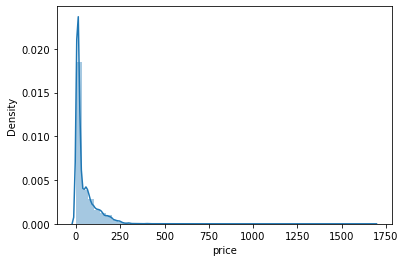

In [18]:
sns.distplot( a=sales.price, hist=True, kde=True, rug=False )

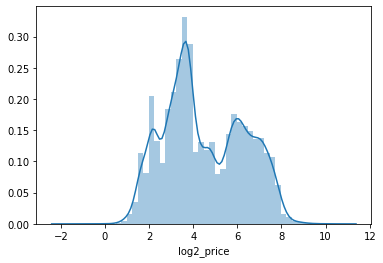

In [240]:
sns.distplot( a=sales.log2_price, hist=True, kde=True, rug=False )

In [33]:
rarity_cols = ['mint','Background_rarity', 'Clothes_rarity', 'Eyes_rarity',
       'Eyewear_rarity', 'Fur_rarity', 'Hat_rarity', 'Mouth_rarity',
       'rarity_rank', 'overall_rarity', 'min_rarity', 'mean_rarity',
       'trait_n']



In [34]:
collection_n_traits = [len(trait_list[i]) for i in collections]

final_rarity_cols = [f"trait_{i}_rarity" for i in np.arange(0, np.min(collection_n_traits))]
final_rarity_cols

['trait_0_rarity',
 'trait_1_rarity',
 'trait_2_rarity',
 'trait_3_rarity',
 'trait_4_rarity',
 'trait_5_rarity']

In [243]:
cat_vars = ['trait_n']
num_cols = ['collection_age','timeDiff','rarity_rank',
             'overall_rarity', 'min_rarity', 'mean_rarity',
             'daily_median_price', 'daily_floor', 'SOL_USD']+final_rarity_cols

training_cols = cat_vars+num_cols

## Combine traits/rarities for all collections into a single df 

- However, traits not comparable across collections... 
- Rarities, however are comparable 
- But we can include single trait rarities, but ordering them buy their effect on price
- For example trait_0_rarity will be the rarity of the trait within the collection which has the highest impact on price 
- Impact on price is defined through a multiple linear regression model

###

In [244]:
# join the sales and rarity dataframes on name
sales_rarity_all = pd.DataFrame()
for i in collections:
    rarity_cols = [s + '_rarity' for s in trait_list[i]]


    sales_rarity = sales.merge(trait_dfs[i],left_on='tokenMint', right_on="mint")
    rarity_price_corr_df = pd.DataFrame()
    y = sales_rarity.log2_price
    for trait_rarity in rarity_cols:
        X = sales_rarity[['daily_median_price',trait_rarity]]
        lm = linear_model.LinearRegression()
        lm.fit(X, y)
        rarity_coeff = np.abs(lm.coef_[1])
        rarity_price_corr_df = rarity_price_corr_df.append({'trait':trait_rarity, 'abs_coeff':rarity_coeff},True)

    rarity_price_corr_df = rarity_price_corr_df.sort_values('abs_coeff',ascending=False).reset_index(drop=True)
    rarity_price_corr_df = rarity_price_corr_df.head(np.min(collection_n_traits))


    for index, row in rarity_price_corr_df.iterrows():
        new_name = f"trait_{index}_rarity"
        sales_rarity = sales_rarity.rename(columns={row.trait:new_name})
        trait_dfs[i] = trait_dfs[i].rename(columns={row.trait:new_name})

    sales_rarity= sales_rarity[training_cols+['log2_price']]  

    sales_rarity_all = sales_rarity_all.append(sales_rarity)

sales_rarity_all.shape

(46425, 17)

In [245]:
trait_dfs[i]

,Unnamed: 0,name,Background,Body,Eyes,Face,Hat,Outfit,trait_0_rarity,trait_2_rarity,trait_3_rarity,trait_4_rarity,trait_5_rarity,trait_1_rarity,rarity_rank,overall_rarity,min_rarity,mean_rarity,trait_n,mint
0,0,Trippin' Ape Tribe #13,Shroom,Galaxy Trypophobia,Radioactive,Ten Strip Blue,Ceremonial Hood,Ceremonial Hood,1.99,2.97,1.91,0.92,0.10,0.10,1,1.038558e-13,0.10,1.331667,6,7ctjpJw5hx2rDQ93c5YCHo7HXTyFdx5tGPTauZbmwrNj
1,1,Trippin' Ape Tribe #16,Dark Shroom,Drippy Radioactive,Radioactive,Substrate,Ceremonial Hood,Ceremonial Hood,2.48,2.61,1.91,0.99,0.10,0.10,2,1.223942e-13,0.10,1.365000,6,9ugemFAtBTdXCCLuwAcjbwko3AVwcRiWVPGDrvNK4irH
2,2,Trippin' Ape Tribe #14,Dark Shroom,Drippy Sol,Radioactive,Substrate,Ceremonial Hood,Ceremonial Hood,2.48,3.66,1.91,0.99,0.10,0.10,3,1.716332e-13,0.10,1.540000,6,8NEcwpkSZVzyf2BiZJ7hnWAcapxkQE6mF3K6y8bqXwVg
3,3,Trippin' Ape Tribe #11,Magenta Swirl,Inferno Trypophobia,Radioactive,Ten Strip,Ceremonial Hood,Ceremonial Hood,2.74,2.46,1.91,1.98,0.10,0.10,4,2.549084e-13,0.10,1.548333,6,Huve9tQoYLFQeiTNdneBiEfGZYxCXWLmjSWc5B6G4YXE
4,4,Trippin' Ape Tribe #15,Purple Swirl,Galaxy Trypophobia,Radioactive,Ten Strip,Ceremonial Hood,Ceremonial Hood,2.39,2.97,1.91,1.98,0.10,0.10,5,2.684435e-13,0.10,1.575000,6,HYkpnuUjuX1ccKSJV3nKFUVzL1PUBkQLiph9MxDJPdWJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,Trippin' Ape Tribe #4791,Light,Marble,Sus,Quiet,Beanie,I _3 Chorles,5.09,10.78,7.50,9.86,8.93,9.71,9996,3.518402e-07,5.09,8.645000,6,92Kh5SuLQ3zBtqoPdLsytoMU6qjgKZnyFoubgDmptDeh
9996,9996,Trippin' Ape Tribe #9666,Lilac,Marble,Sus,Shout,Beanie,I _3 Chorles,6.43,10.78,7.50,7.91,8.93,9.71,9997,3.565646e-07,6.43,8.543333,6,9eq8Yuv7pozL1mnNNqC93XjCbtKVnXZzBGYJSCcwnXZc
9997,9997,Trippin' Ape Tribe #9390,Beige,Purple Tryptamine,Alert Red,Eyeball,Beanie,I _3 Chorles,6.36,10.91,7.79,7.69,8.93,9.71,9998,3.604262e-07,6.36,8.565000,6,8tmwqdjKhdUKisG7kPvCGR2MkpmesUsZgWikCCUkAzyo
9998,9998,Trippin' Ape Tribe #2932,Peach,Purple Tryptamine,Alert Red,Quiet,NaN,I _3 Chorles,4.88,10.91,7.79,9.86,9.26,9.71,9999,3.676962e-07,4.88,8.735000,5,CSxbu3r62DC7F6CWMepsTjhQFz4im2dGEAswdNLwW81h


In [162]:
sales_rarity_all.columns



Index(['trait_n', 'collection_age', 'timeDiff', 'rarity_rank',
       'overall_rarity', 'min_rarity', 'mean_rarity', 'daily_median_price',
       'daily_floor', 'SOL_USD', 'trait_0_rarity', 'trait_1_rarity',
       'trait_2_rarity', 'trait_3_rarity', 'trait_4_rarity', 'trait_5_rarity',
       'log2_price'],
      dtype='object')

In [163]:
#define target varaible as price in solana 

y = sales_rarity_all.log2_price
preprocess_df = sales_rarity_all.copy()
preprocess_df.drop(columns=['log2_price'], inplace=True)


In [164]:
preprocess_df.head(4)


,trait_n,collection_age,timeDiff,rarity_rank,overall_rarity,min_rarity,mean_rarity,daily_median_price,daily_floor,SOL_USD,trait_0_rarity,trait_1_rarity,trait_2_rarity,trait_3_rarity,trait_4_rarity,trait_5_rarity
0,6,824226,4452431,9995,7.637470e-07,3.17,20.604286,6.50,4.60,31.55,3.17,19.44,10.10,11.98,13.80,75.97
1,6,34594,3662799,9995,7.637470e-07,3.17,20.604286,10.00,7.29,38.89,3.17,19.44,10.10,11.98,13.80,75.97
2,6,824195,4452400,6610,9.292244e-08,2.83,18.088571,6.50,4.60,31.55,2.83,19.44,10.28,6.03,6.78,75.97
3,6,5324,3633529,6610,9.292244e-08,2.83,18.088571,13.85,9.30,40.49,2.83,19.44,10.28,6.03,6.78,75.97


In [165]:
#create binary dummary varaib
preprocess_df = pd.get_dummies(preprocess_df, columns=cat_vars   )
preprocess_df.shape

(46425, 19)

In [166]:
#scale numeric variables
ss = StandardScaler()
ss= ss.fit(preprocess_df[num_cols])
preprocess_df[num_cols] = ss.transform(preprocess_df[num_cols])


In [167]:
preprocess_df.head(4)

,collection_age,timeDiff,rarity_rank,overall_rarity,min_rarity,mean_rarity,daily_median_price,daily_floor,SOL_USD,trait_0_rarity,trait_1_rarity,trait_2_rarity,trait_3_rarity,trait_4_rarity,trait_5_rarity,trait_n_4,trait_n_5,trait_n_6,trait_n_7
0,0.563768,1.109736,1.646123,0.921565,0.866745,1.536562,-0.705159,-0.657885,-0.868005,-0.464028,1.813287,0.378297,0.972079,1.085674,1.939976,0,0,1,0
1,-0.498810,0.633916,1.646123,0.921565,0.866745,1.536562,-0.639937,-0.599699,-0.585843,-0.464028,1.813287,0.378297,0.972079,1.085674,1.939976,0,0,1,0
2,0.563726,1.109717,0.466291,-0.049503,0.570078,1.101508,-0.705159,-0.657885,-0.868005,-0.545746,1.813287,0.408681,-0.135574,-0.179957,1.939976,0,0,1,0
3,-0.538197,0.616278,0.466291,-0.049503,0.570078,1.101508,-0.568194,-0.556222,-0.524336,-0.545746,1.813287,0.408681,-0.135574,-0.179957,1.939976,0,0,1,0


In [168]:
# create train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    preprocess_df, y, test_size=0.15, random_state=42
)


print(f"train set has {x_train.shape[0]} datapoints and test set has {x_test.shape[0]} datapoints")


train set has 39461 datapoints and test set has 6964 datapoints


In [169]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,max_depth=10
)
#fit the model
xgb_model.fit(x_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [172]:
#prediction on test set
xgb_ypred = xgb_model.predict(x_test)
MAPE(predicted=xgb_ypred, actual=y_test, log2_input=True)

--------------------------------
Testing Model Absolute Percentage error (APE)
Median APE (MAPE) = 4.14%
Mean APE  = 8.66 %
25th percentile APE = 1.78 %
75th percentile APE = 8.55 %


In [174]:
#calculate MSE
xgb_mse = MSE(2**y_test, 2**xgb_ypred)
print(f"XGBoost Mean-squared Error = {xgb_mse} SOL")

XGBoost Mean-squared Error = 156.02830690259185 SOL


In [181]:
feat_imp = xgb_model.feature_importances_
sorted_idx = feat_imp.argsort()[::-1]
sorted_idx2 = sorted_idx[2:len(sorted_idx)]


feat_imp[sorted_idx]

array([7.7338421e-01, 2.0540746e-01, 9.2217317e-03, 2.7130235e-03,
       2.1663643e-03, 1.2966406e-03, 9.8924909e-04, 6.7910313e-04,
       6.5559178e-04, 6.0242455e-04, 5.8715825e-04, 5.2445394e-04,
       4.6659374e-04, 3.3702247e-04, 2.2615970e-04, 2.2382352e-04,
       1.8422487e-04, 1.7917545e-04, 1.5556545e-04], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

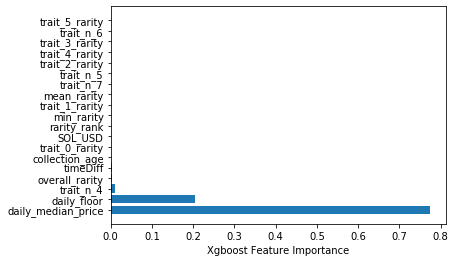

In [182]:
plt.barh(x_train.columns[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Text(0.5, 0, 'Xgboost Feature Importance')

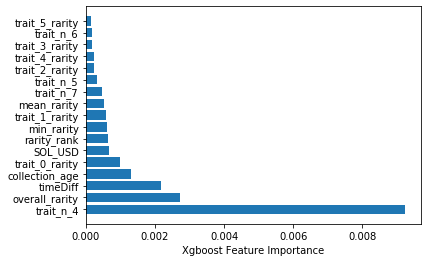

In [183]:
plt.barh(x_train.columns[sorted_idx2], feat_imp[sorted_idx2])
plt.xlabel("Xgboost Feature Importance")

In [185]:
fig = px.scatter(x=2**xgb_ypred, y=2**y_test, trendline="ols",opacity =0.3, 
        labels={
                     "x": "Predicted Sale Price (SOL)",
                     "y": "Actual Sale Price (SOL)"
                 })
fig.show()

In [259]:
for i in collections:
    x_predict = trait_dfs[i].copy()
    collection_sales = sales[sales.collection ==i]
    x_predict = pd.get_dummies(x_predict, columns =cat_vars)

    latest_sale = collection_sales[collection_sales.timeDiff ==collection_sales.timeDiff.max()].reset_index(drop=True)

    cols2add = ['collection_age', 'timeDiff','daily_median_price', 'daily_floor','SOL_USD']
    for trait in cols2add:
        x_predict[trait] = latest_sale[trait][0]


    #get trained columns
    trained_vars = x_train.columns.to_list()

    if 'trait_n_7' not in x_predict.columns:
        x_predict['trait_n_7']=0

    x_predict = x_predict[['name']+trained_vars]
    x_predict[num_cols] = ss.transform(x_predict[num_cols])

    prediction = xgb_model.predict(x_predict[trained_vars])

    x_predict['pred_SOL'] = 2**prediction
    x_predict.head()

    pred_price = trait_dfs[i].merge( x_predict[['name','pred_SOL']],on='name').sort_values('pred_SOL',ascending=False)
    pred_price.to_csv(f"data/{i}/predicted.csv")


In [326]:
xgb2 = xgb.XGBRegressor(nthread=-1,seed=42,objective ="reg:squarederror" )

xg_grid = GridSearchCV(xgb2, 
                       param_grid={'n_estimators':[500,1750],
                                    'max_depth': [2,6,8,10,12,14],
                                    'subsample':[0.2,0.5,0.7,0.95,1.0],
                                    'colsample_bytree':[0.3,0.7,0.9,1.0],
                                    'eta':[0.01,0.1,0.25,0.5],
                                    'learning_rate':[0.1,0.3,0.4]},
                        cv=10, n_jobs=-1,scoring='neg_mean_absolute_error')


#fit the model
xg_grid.fit(x_train, y_train)



In [247]:
xg_grid.best_params_

{'colsample_bytree': 0.7,
 'eta': 0.5,
 'max_depth': 6,
 'n_estimators': 1500,
 'subsample': 0.2}

In [250]:
xg_grid.best_score_

0.9999961069959463

Text(0.5, 0, 'Xgboost Feature Importance')

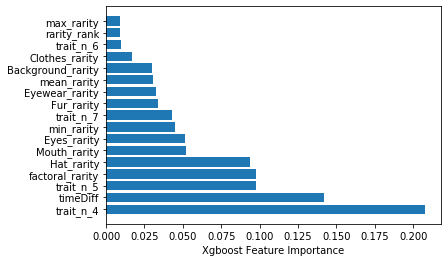

In [251]:

feat_imp = xg_grid.best_estimator_.feature_importances_
sorted_idx = feat_imp.argsort()[::-1]

plt.barh(x_train[cols2fit].columns[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [252]:
fig = px.scatter(x=xgb2_ypred, y=y_test)
fig.show()

In [254]:
print(f"max = {y.max()}, mean = {y.min()}, mean = {y.mean()}, median = {y.median()}")

max = 666.66, mean = 6.49, mean = 118.69156945758608, median = 112.5


,name,Background,Clothes,Eyes,Eyewear,Fur,Hat,Mouth,trait_n,mean_rarity,rarity_rank,predicted_SOL
52,Okay Bear #9638,Warm Grey,NaN,Interested,NaN,Tan,NaN,Cassette,4,0.209586,53,645.875732
9041,Okay Bear #9989,Green,NaN,White Glow,NaN,Tan,NaN,Oou,4,0.208857,9042,465.047455
9341,Okay Bear #2373,Blue,NaN,White Glow,NaN,Tan,NaN,Huh,4,0.209786,9342,442.157379
9331,Okay Bear #1726,Warm Grey,NaN,White Glow,NaN,Tan,NaN,Huh,4,0.209429,9332,439.765839
9224,Okay Bear #8057,Yellow,NaN,Closed,NaN,Tan,NaN,Huh,4,0.208914,9225,421.374817
9182,Okay Bear #8352,Cream,NaN,Golden Glow,NaN,Tan,NaN,Clean Smile,4,0.215286,9183,419.339569
9160,Okay Bear #1478,Purple,NaN,Golden Glow,NaN,Grizzly,NaN,Clean Smile,4,0.213686,9161,414.372894
9697,Okay Bear #2362,White,NaN,Closed,NaN,Polar,NaN,Okay,4,0.226514,9698,410.850800
9173,Okay Bear #8134,Blue,NaN,Golden Glow,NaN,Grizzly,NaN,Clean Smile,4,0.214614,9174,410.083466
9806,Okay Bear #9544,Blue,NaN,White Glow,NaN,Sand,NaN,Okay,4,0.229300,9807,403.100006


In [290]:
predict_SOL.predicted_SOL.median()
predict_SOL.to_csv('data/okay_bear/okay_bears_pred.csv')